<a href="https://colab.research.google.com/github/leukschrauber/Assignments/blob/main/assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [9]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

#Theory

In the following assignment, your task is to complete the MNIST Basics chapter. It is best to repeat everything from last week and try to answer the following questions. Afterwards you have to summarize the learned facts with two programming tasks.

**What is "torch.cat()" and ".view(-1, 28*28)" doing in the beginning of the "The MNIST Loss Function" chapter?**

torch.cat concatenates two tensors, meaning that it appends the one to the other.

torch.view is able to manipulate the rank of tensors. In this, example where we had a tensor of shape (N, 28, 28), view reduces the dimensions by 1, resulting in a tensor of shape (N, 28*28).

**Can you draw the neuronal network, which is manually trained in chapter "The MNIST Loss Function"?**

In the chapter "The MNIST Loss Function", a neuronal network with a single input layer of 784 inputs and a single bias is trained. The Sigmoid function is applied as a step function at the end of the network to map the values to a number between -1 and 1.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


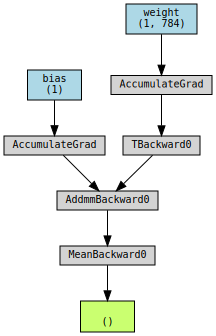

In [10]:
linear_model = nn.Linear(28*28,1)

!pip install torchviz
from torchviz import make_dot

make_dot(linear_model(valid_x).mean(), params=dict(linear_model.named_parameters()))




**Why is it not possible to use the accuracy as loss function?**

The accuracy for a single prediction is defined as 0 (false) for wrong prediction and 1 (true) for a true prediction. The outcome of a network will always be mapped to one of these two constant values. The slope of a constant is always zero. It is infinity for the border between the two value mappings. As we need slopes for backpropagation in Stochastic Gradient Descent, a function with a slop of zero is not suitable.


**What is the defined `mnist_loss` function doing? **


```
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()
```

This function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances. It works similary to a ternary if-else operator, just on a pyTorch Tensor.

**Why do we need additionaly the sigmoid() function? What is it technically in our TLU?**

The sigmoid function maps the output of the network to a value between -1 and 1. Thus, every value < 0 can be defined as one class and every value > 0 can be defined as the other class in our classification problem. Additionally, it has a well-defined slope for every x enabling a meaningful Stochastic Gradient Descent. It is our step function.

**Again, what are mini batches, why are we using them and why should they be shuffeld?**

The question is how many data items are suitable for performing a single optimization step. The size should be just big enough to provide a consistent and meaningful stochastic gradient descent. A single item will be rather inconsistent and the whole data set (epoch) will take too long often. 

Shuffling the batches helps reduce the risk of overfitting and will overall merge into better results as local optima are mitigated.

#Practical Part

Try to understand all parts of the code needed to manually train a single TLU/Perceptron, so use and copy all parts of the code from "First Try: Pixel Similarity" to the "Putting it all together" chapter. In the second step, use an optimizer, a second layer, and a ReLU as a hidden activation function to train a simple neural network. When copying the code, think carefully about what you really need and how you can summarize it as compactly as possible. (Probably each attempt requires about 15 lines of code.)

In [11]:
# Used to initialize weights and bias
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

# Matrix multiplication of a input matrix and weights + bias. This is the network.
def linear1(xb): return xb@weights + bias

# Loss function: Difference between sigmoid and correct value.
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

# Calculates the gradient for the Stochastic Gradient Descent
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

# Trains an epoch with n mini batches in the dataloader.
# Performs an optimization step for every mini batch using the learning rate.
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

# Calculates the accuracy for the predictions. Not really necessary for the network
# but great for human understanding.
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

# Using the validation dataloader, calculates an accuracy for preds.
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

# Weights and bias
weights = init_params((28*28,1))
bias = init_params(1)
# The data sets and data loaders for both training and validation.
dl = DataLoader(list(zip(train_x,train_y)), batch_size=256)
valid_dl = DataLoader(list(zip(valid_x,valid_y)), batch_size=256)

# The training loop. 20 epochs. 1.0 Learning Rate
for i in range(20):
    train_epoch(linear1, 1.0, (weights,bias))
    print(validate_epoch(linear1), end=' ')

0.4947 0.5935 0.7938 0.8886 0.9281 0.9384 0.9477 0.954 0.9589 0.9613 0.9643 0.9643 0.9677 0.9667 0.9676 0.9681 0.9691 0.9706 0.9706 0.9711 

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.310629,0.406701,0.508341,00:00
1,0.143736,0.228092,0.803238,00:00
2,0.079770,0.114890,0.916585,00:00
3,0.052617,0.077463,0.941119,00:00
4,0.040036,0.060461,0.956330,00:00
5,0.033613,0.050974,0.964181,00:00
6,0.029924,0.045003,0.965653,00:00
7,0.027524,0.040925,0.967615,00:00
8,0.025788,0.037957,0.969087,00:00
9,0.024438,0.035687,0.971541,00:00


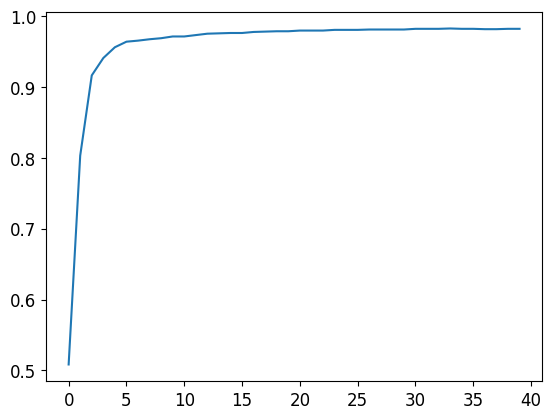

In [12]:
# Build the model: 784 weights -> 30 outputs. ReLU Activation Function. 30 Inputs -> 1 Output
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

# Loss function: Difference between sigmoid and correct value.
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

# Calculates the accuracy for the predictions. Not really necessary for the network
# but great for human understanding.
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

# The data sets and data loaders for both training and validation.
dl = DataLoader(list(zip(train_x,train_y)), batch_size=256)
valid_dl = DataLoader(list(zip(valid_x,valid_y)), batch_size=256)

# Learner takes test and validation dataset, the model, the SGD for optimization, 
# the minst_loss function for calculating the loss, the batch_accuracy for validation
learn = Learner(DataLoaders(dl, valid_dl), simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

plt.plot(L(learn.recorder.values).itemgot(2));